# 02/22/24 - Adding covariance matrix to the space_jam method
# 02/12/24 - Adding least squares fitting option to forgo the time consuming MCMC for testing purposes.
# 12/26/23 - This notebook tests the modules "space_jam" and "total_mass_mge" in e.g. home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
#plt.switch_backend('agg')
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
#from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
# bring in the space_jam and total_mass_mge modules

from space_jam import space_jam
from total_mass_mge import total_mass_mge

In [51]:
##################################################################################################################################

old_date_of_kin = '2023-02-28_2'
date_of_kin = '2024_02_15'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
old_kinematics_dir = f'{kinematics_full_dir}{old_date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')

# I need to get the systematic uncertainties from the old marginalized stuff.

In [11]:
SN = 15

In [61]:
Vrms_array_old = np.empty(len(obj_names), dtype=object)
dVrms_array_old = np.empty(len(obj_names), dtype=object)

In [62]:
for i, obj_name in enumerate(obj_names):
    
    obj_abbr = obj_name[4:9]
    
    obj_kin_dir = f'{old_kinematics_dir}{obj_name}/'

    # J0330 has no G-band
    if obj_abbr=='J0330':
        target_kin_dir = f'{obj_kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{obj_kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'

    # take the surface density, etc from mge saved parameters
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf_lum = tommy_pickles.surf_density
    sigma_lum = tommy_pickles.mge_sigma
    qobs_lum = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    #try:
    #    sigmapsf = tommy_pickles.kcwi_sigmapsf
    #except:
    #    sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms = tommy_pickles.Vrms_bin
    try:
        dVrms = tommy_pickles.dVrms_bin 
    except:
        dVrms = tommy_pickles.dVrms_bind # mistake in name
    V = tommy_pickles.V_bin
    dV = tommy_pickles.dV_bin
    xbin = tommy_pickles.xbin_phot
    ybin = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    dVrms_array_old[i] = dVrms
    Vrms_array_old[i] = Vrms

In [66]:
np.nanmean(dVrms_array_old[0]/Vrms_array_old[0])

0.0544810640824828

In [64]:
mean_err = np.ones(14)

In [67]:
for i in range(14):
    mean_err[i] = np.nanmean(dVrms_array_old[i]/Vrms_array_old[i])

In [68]:
%matplotlib inline

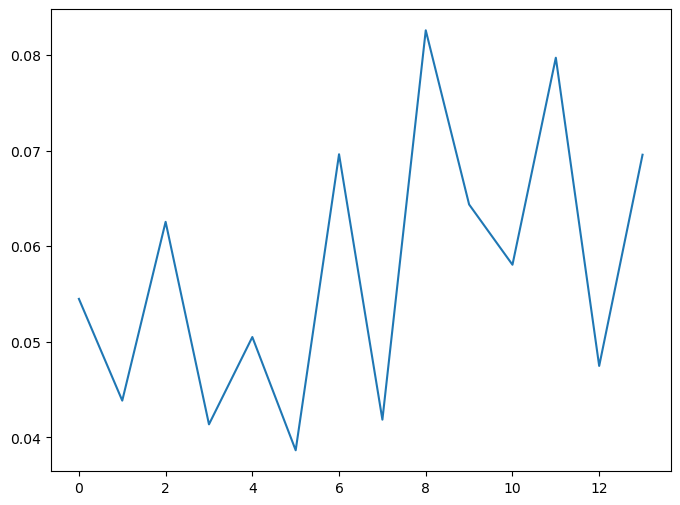

In [69]:
plt.plot(range(14), mean_err)
plt.pause(1)

# This included both statistical and systematic errors. Take the new uncertainties

In [58]:
Vrms_array_new = np.empty(14, dtype=object)
dVrms_array_new = np.empty(14, dtype=object)

In [59]:
for i, obj_name in enumerate(obj_names):
    
    obj_abbr = obj_name[4:9]
    
    obj_kin_dir = f'{kinematics_dir}{obj_name}/'

    # take the surface density, etc from mge saved parameters
    with open(f'{obj_kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf_lum = tommy_pickles.surf_density
    sigma_lum = tommy_pickles.mge_sigma
    qobs_lum = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    #try:
    #    sigmapsf = tommy_pickles.kcwi_sigmapsf
    #except:
    #    sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms = tommy_pickles.Vrms_bin
    try:
        dVrms = tommy_pickles.dVrms_bin 
    except:
        dVrms = tommy_pickles.dVrms_bind # mistake in name
    V = tommy_pickles.V_bin
    dV = tommy_pickles.dV_bin
    xbin = tommy_pickles.xbin_phot
    ybin = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    dVrms_array_new[i] = dVrms
    Vrms_array_new[i] = Vrms

In [75]:
mean_err_new = np.ones(14)

for i in range(14):

    mean_err_new[i] = np.nanmean(dVrms_array_new[i]/Vrms_array_new[i])

In [76]:
mean_err_new

array([0.04323521, 0.03103349, 0.05036809, 0.02497144, 0.03445513,
       0.03337771, 0.04671045, 0.02908642, 0.04386272, 0.04210362,
       0.04830318, 0.0565505 , 0.03676382, 0.03945588])

In [77]:
syst_err = np.sqrt(mean_err**2 - mean_err_new**2)

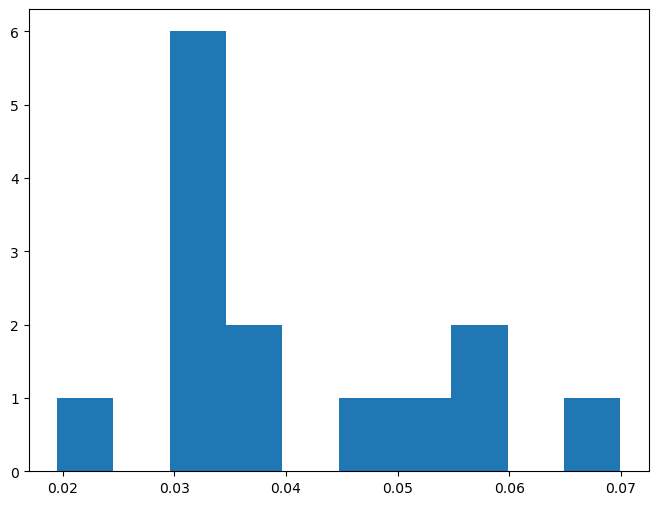

In [79]:
plt.hist(syst_err)
plt.pause(1)

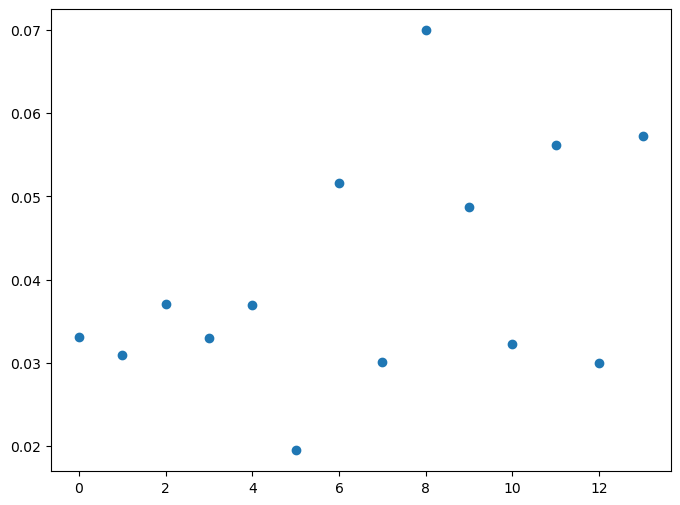

In [80]:
plt.scatter(range(14), syst_err)

In [81]:
np.mean(syst_err)

0.0404668949124014

# Okay, I think I just give each of them 5% systematic error (in diagonals, squared)

In [82]:
mean_err_new

array([0.04323521, 0.03103349, 0.05036809, 0.02497144, 0.03445513,
       0.03337771, 0.04671045, 0.02908642, 0.04386272, 0.04210362,
       0.04830318, 0.0565505 , 0.03676382, 0.03945588])

# Add 2% for off-diagonal covariance

In [84]:
dVrms_array_new[0]

array([ 5.08286057,  5.10938017,  6.03996515,  5.80040451,  5.69593251,
        7.71579744,  5.64208097,  6.8450093 ,  5.93714766,  8.3007249 ,
        8.91558727,  9.01892046,  7.22304908, 11.50180813, 11.67925599,
       11.70013624, 10.7582847 ,  8.48576482,  6.61028478,  6.14485149,
        4.64814082,  9.80234794,  8.74317904,  7.18785958,  6.15630855,
        7.50506176, 13.74277532, 14.84625081, 14.19588357, 13.7528228 ,
       11.21782255,  9.63014078, 14.45364683, 12.45934253,  8.3489568 ,
        7.3307587 ,  7.0238381 , 13.4733244 ,  7.0007897 , 15.71121432,
        9.66134911,  6.75540822,  8.5994706 ,  6.47166362,  7.63174321,
        8.3130873 ,  6.98535417, 14.79764084,  7.98900033,  9.85055824,
       10.90242044,  7.84686333,  8.39414217, 12.27025903, 13.09368783,
       12.09541554, 14.44255846, 11.87704594, 17.25857683])

In [97]:
# make an array of size dVrms[0]
dVrms = dVrms_array_new[0]
Vrms = Vrms_array_new[0]

# make a covariance matrix without systematics or covariance
cov_matrix_no_cov = np.identity(dVrms.size) * dVrms**2

# add constant 5% systematics in quadrature
cov_matrix_no_cov_w_syst = cov_matrix_no_cov + np.identity(dVrms.size) * (Vrms*0.05)**2

# make a 


In [106]:
xx, yy = np.meshgrid(Vrms, Vrms)

In [118]:
xx, yy = np.meshgrid(Vrms, Vrms)
off_diagonals = (xx * yy * 0.03**2)
off_diagonals = off_diagonals - np.identity(Vrms.size) * off_diagonals.diagonal()

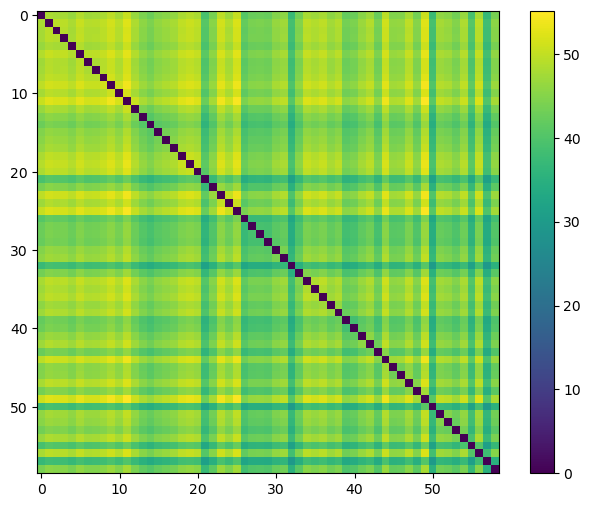

In [119]:
plt.imshow(off_diagonals)
plt.colorbar()

In [120]:
cov_matrix = cov_matrix_no_cov_w_syst + off_diagonals

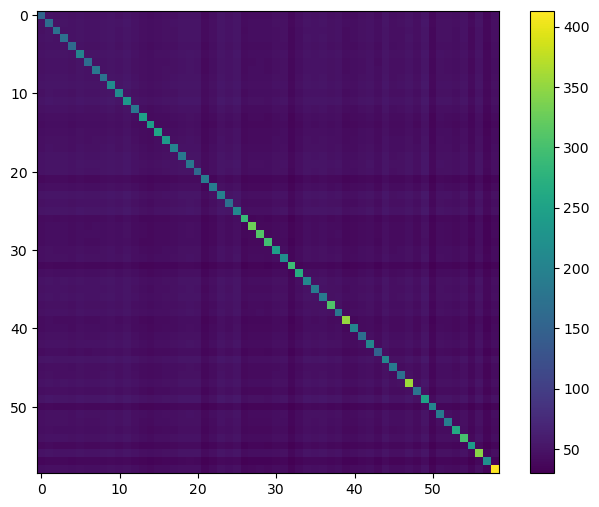

In [123]:
plt.imshow(cov_matrix)
plt.colorbar()

In [124]:
def approximate_covariance_matrix (self, systematics, covariance):
    
    Vrms = self.Vrms_bin
    dVrms = self.dVrms_bin
    
    # make a covariance matrix without systematics or covariance
    cov_matrix_no_cov = np.identity(dVrms.size) * dVrms**2

    # add constant 5% systematics in quadrature
    cov_matrix_no_cov_w_syst = cov_matrix_no_cov + np.identity(dVrms.size) * (Vrms*0.05)**2
    
    # calculate grid of Vrms for off-diagonal covariance terms
    xx, yy = np.meshgrid(Vrms, Vrms)
    off_diagonals = (xx * yy * 0.03**2)
    # make diagonal 0
    off_diagonals = off_diagonals - np.identity(Vrms.size) * off_diagonals.diagonal()
    
    # add the off-diagonals to the covariance matrix
    self.covariance_matrix = cov_matrix_no_cov_w_syst + off_diagonals

# Multiple core framework

# SuperFastPython.com
# example of a program that uses all cpu cores
import math
from concurrent.futures import ProcessPoolExecutor
 
# define a cpu-intensive task
def task(arg):
    return sum([math.sqrt(i) for i in range(1, arg)])
 
# protect the entry point
if __name__ == '__main__':
    # report a message
    print('Starting task...')
    # create the process pool
    with ProcessPoolExecutor(8) as exe:
        # perform calculations
        results = exe.map(task, range(1,50000))
    # report a message
    print('Done.')

In [23]:

# define the task
def task(i):

    obj_name = obj_names[i]
    SN = 15
    mass_model='power_law'
    anisotropy='const'
    geometry='axi'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    p0 = [2.0, 0.4, 0.9, 1.0, 0.5, 7] # gamma0, q0, k_ani, einstein radius, k_mst, a_mst
    bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
              [2.8, 1.0,   1.0, 2.0, 1.0, 10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 10
    nwalkers = 12
    ndim = 6
    minimization = 'lsq'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
    run_id = 1

    welcome_to_the_jam = space_jam(kinematics_dir, jam_output_dir,
                                     obj_name, SN, mass_model, anisotropy, geometry, align, 
                                    zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=False, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)
    
    welcome_to_the_jam.fit_lsq()
    welcome_to_the_jam.save_space_jam()

Starting task...

Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_22_v1/ will be overwritten.Outputs to 
 
/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1204+0358_2024_02_22_v1/
Outputs to 
 /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_22_v1/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0330-0020_2024_02_22_v1/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']

/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py:312: RuntimeWarning: divide by zero encountered in divide
  self.goodbins = np.isfinite(self.Vrms/self.dVrms)



Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]
Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1402+6321_2024_02_22_v1/


Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1250+0523_2024_02_22_v1/

Priors are now 
Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1112+0826_2024_02_22_v1/

 Priors are now ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']


/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py:312: RuntimeWarning: divide by zero encountered in divide
  self.goodbins = np.isfinite(self.Vrms/self.dVrms)



Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1306+0600_2024_02_22_v1/

Mean prior values are  
Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942_2024_02_22_v1/

 Priors are now ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform'] 
[2.0, 0.74, 0.9, 1.0, 0.5, 7]['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']Mean prior values are Priors are now  

Priors are now  Mean prior values are  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]
 [2.0, 0.74, 0.9, 1.0, 0.5, 7][2.0, 0.74, 0.9, 1.0, 0.5, 7]['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']


Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope`

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:940: RuntimeWarning: divide by zero encountered in divide
  d, m = (data/errors)[goodbins], (model/errors)[goodbins]


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:940: RuntimeWarning: divide by zero encountered in divide
  d, m = (data/errors)[goodbins], (model/errors)[goodbins]


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()



iter: 5  lambda: 673.7  chi2: 272.2  ratio: 1.000
p_free: 2.088 0.8626 0.000 1.422
h: -0.0008958 -0.006964 0.000 0.005349
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 35.87  chi2: 31.47  ratio: -0.7742
p_free: 1.946 0.7405 0.000 1.158
h: -0.01187 0.000 0.000 0.0003425

iter: 4  lambda: 503.2  chi2: 157.3  ratio: 1.041
p_free: 2.158 0.8334 0.000 0.9462
h: -0.009872 0.000 0.000 0.001821


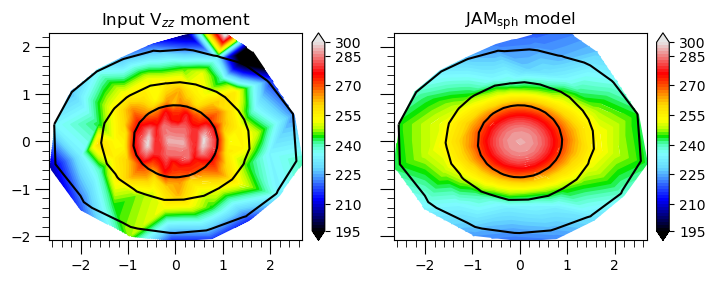

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942_2024_02_22_v1/SDSSJ0037-0942_2024_02_22_v1_space_jam.pkl

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1538+5817_2024_02_22_v1/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 143.5  chi2: 31.44  ratio: -0.6003
p_free: 1.947 0.7405 0.000 1.157
h: -0.01033 0.000 0.000 -0.0004828
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()



iter: 6  lambda: 36.82  chi2: 209.9  ratio: 0.8644
p_free: 2.251 0.9693 0.5521 1.129
h: 0.0005991 0.01722 -0.01579 -0.001569
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


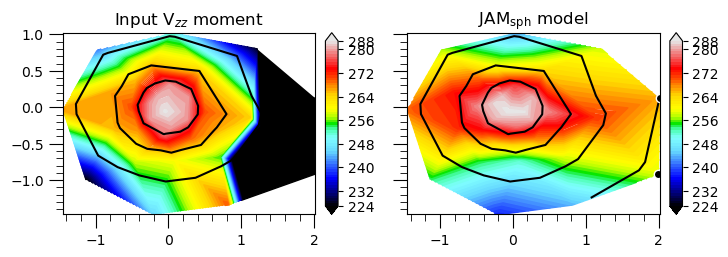


iter: 5  lambda: 28.14  chi2: 210.4  ratio: 0.6770
p_free: 2.095 0.7412 0.000 1.370
h: -0.006261 0.000 0.000 0.007833

iter: 3  lambda: 5.581  chi2: 63.53  ratio: 1.007
p_free: 2.243 0.6719 0.4809 1.692
h: -0.03781 0.000 0.1888 0.02589
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1112+0826_2024_02_22_v1/SDSSJ1112+0826_2024_02_22_v1_space_jam.pkl

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1621+3931_2024_02_22_v1/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 5  lambda: 251.6  chi2: 157.3  ratio: 1.076
p_free: 2.155 0.8334 0.00

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 6  lambda: 1801.  chi2: 210.4  ratio: 0.02964
p_free: 2.098 0.7412 0.000 1.368
h: 0.002572 0.000 0.000 -0.001603
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 7  lambda: 7.541e+04  chi2: 209.9  ratio: 0.1673
p_free: 2.251 0.9668 0.5521 1.129
h: -1.730e-05 -0.002433 -1.940e-05 0.0001142


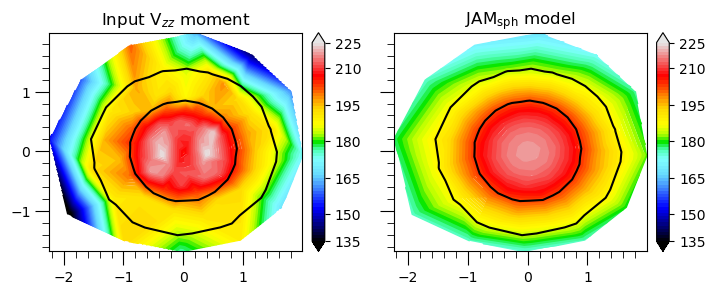

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_22_v1/SDSSJ0029-0055_2024_02_22_v1_space_jam.pkl

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1627-0053_2024_02_22_v1/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  
iter: 3  lambda: 19.23  chi2: 139.4  ratio: -1.157
p_free: 2.246 0.8105 0.5210 1.151
h: -0.006174 0.000 0.2363 -0.03916
[2.0, 0.74, 0.9, 1.0, 0.5, 7]
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
iter: 2  lambda: 29.90  chi2: 116.3  ratio: 0.9844
p_free: 2.076 0.6989 0.1699 1.224
h: -0.1189 -0.04462 0.1699 -0.01721

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ng

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


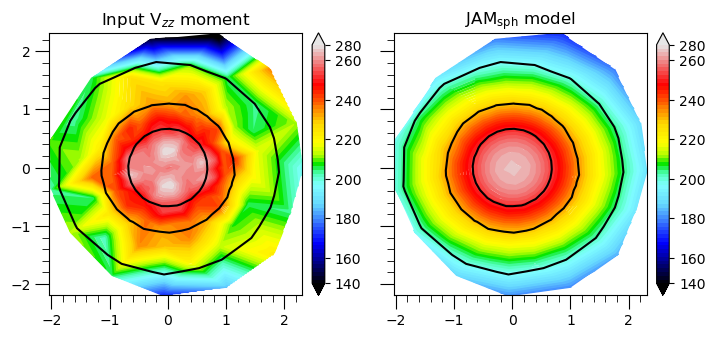


iter: 7  lambda: 7205.  chi2: 210.4  ratio: 0.1488
p_free: 2.097 0.7412 0.000 1.369
h: -0.0004923 0.000 0.000 0.001006

Terminating on small function variation (ftol)
Final iter: 7  Func calls: 39  chi2: 210.4  Status: 2
Final p: 2.097 0.7412 0.000 1.369


Success!

Best fit, [2.09729987 0.74123789 0.         1.36899821 0.5        7.        ]
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1204+0358_2024_02_22_v1/SDSSJ1204+0358_2024_02_22_v1_space_jam.pkl

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1630+4520_2024_02_22_v1/



/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py:312: RuntimeWarning: divide by zero encountered in divide
  self.goodbins = np.isfinite(self.Vrms/self.dVrms)


Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]

iter: 4  lambda: 44.65  chi2: 63.49  ratio: 0.2682
p_free: 2.233 0.6719 0.3856 1.696
h: -0.01029 0.000 -0.09532 0.004013
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Start lambda: 74.32  chi2: 2050.
Start p_free: 2.000 0.7400 0.9000 1.000
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:940: RuntimeWarning: divide by zero encountered in divide
  d, m = (data/errors)[goodbins], (model/errors)[goodbins]
/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()



iter: 3  lambda: 14.95  chi2: 128.7  ratio: -1.751
p_free: 2.124 0.6940 0.3887 1.349
h: 0.04817 -0.004810 0.2187 0.1256
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 8  lambda: 3.673e+04  chi2: 31.35  ratio: -1.658
p_free: 1.956 0.7405 0.000 1.156
h: 4.449e-05 0.000 0.000 -2.508e-05

Both ftol and xtol convergence test are satisfied
Final iter: 8  Func calls: 46  chi2: 31.35  Status: 4
Final p: 1.956 0.7405 0.000 1.156


Success!

Best fit, [1.95558971 0.74052585 0.         1.15624704 0.5        7.   

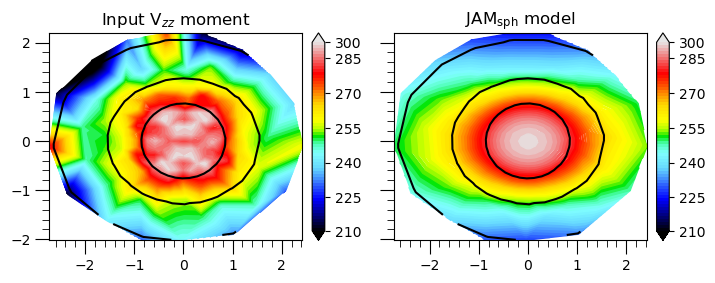

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1402+6321_2024_02_22_v1/SDSSJ1402+6321_2024_02_22_v1_space_jam.pklResiduals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ2303+1422_2024_02_22_v1/
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 2461.  chi2: 105.6  ratio: 0.4804
p_free: 2.247 0.8105 0.4331 1.192
h: -0.003392 0.000 -0.01468 0.01167
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Start lambda: 256.7  chi2: 9346.
Start p_free: 2.000 0.7400 0.9000 1.000


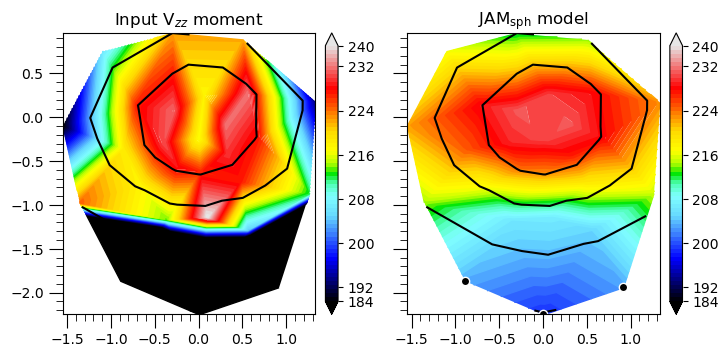

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0330-0020_2024_02_22_v1/SDSSJ0330-0020_2024_02_22_v1_space_jam.pkl
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 1  lambda: 256.7  chi2: 881.6  ratio: 0.9211
p_free: 2.265 0.7251 0.000 1.404
h: 0.2647 -0.01487 -0.9000 0.4040
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` 

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()



iter: 4  lambda: 59.80  chi2: 112.8  ratio: 0.8097
p_free: 2.142 0.7567 0.3282 1.273
h: 0.05141 0.04296 0.06456 -0.02981
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 2  lambda: 37.16  chi2: 158.1  ratio: 0.9939
p_free: 2.047 0.6568 0.2002 1.372
h: -0.03509 0.05685 0.2002 0.01623Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


iter: 5  lambda: 44.65  chi2: 63.41  ratio: 0.8920
p_free: 2.232 0.6719 0.4162 1.704
h: -0.001194 0.000 0.03057 0.008541


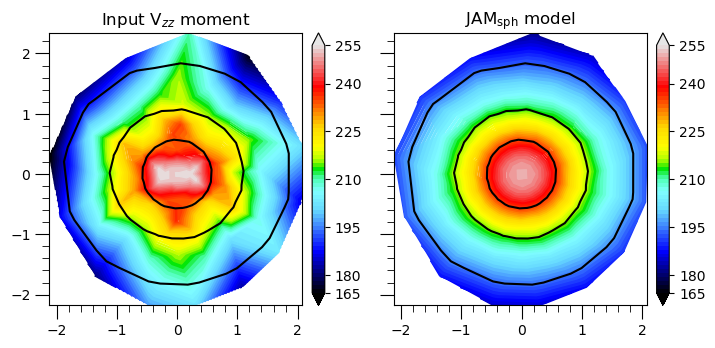

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1250+0523_2024_02_22_v1/SDSSJ1250+0523_2024_02_22_v1_space_jam.pkl
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Start lambda: 36.94  chi2: 2522.
Start p_free: 2.000 0.6734 0.9000 1.000
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 2  lambda: 128.3  chi2: 171.9  ratio: 0.9662
p_free: 2.158 0.8006 0.1376 1.396
h: -0.1071 0.07547 0.1376 -0.007817
Residuals > 10%: Change `inner_slope` or `outer_slope`

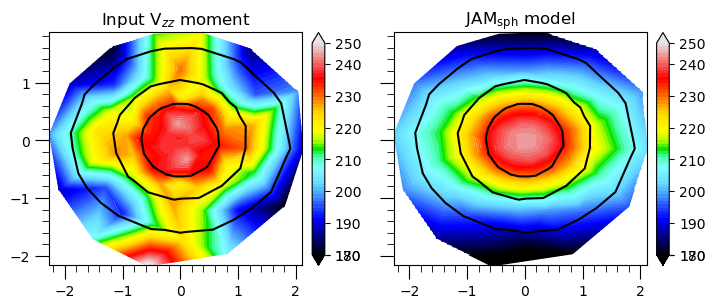

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 5  lambda: 7.838e+06  chi2: 112.7  ratio: 0.3363
p_free: 2.141 0.7590 0.3287 1.274
h: -0.0007095 0.002269 0.0005178 8.274e-05

Terminating on small step (xtol)
Final iter: 5  Func calls: 36  chi2: 112.7  Status: 3
Final p: 2.141 0.7590 0.3287 1.274


Success!

Best fit, [2.14122791 0.75901111 0.32871388 1.27357924 0.5        7.        ]
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1538+5817_2024_02_22_v1/SDSSJ1538+5817_2024_02_22_v1_space_jam.pkl
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 9.236  chi2: 132.3  ratio: -3.546
p_free: 1.893 0.6734 0.000 1.407
h: 0.002379 0.000 0.000 -0.03888
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10

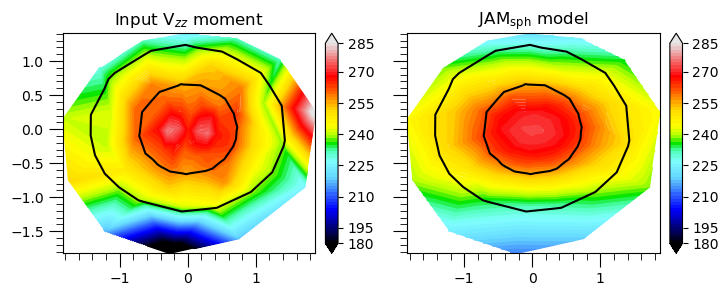

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 7  lambda: 2.286e+04  chi2: 63.41  ratio: -0.1085
p_free: 2.231 0.6719 0.4159 1.704
h: -0.0002476 0.000 -0.0002772 2.217e-05

Terminating on small function variation (ftol)
Final iter: 7  Func calls: 43  chi2: 63.41  Status: 2
Final p: 2.231 0.6719 0.4161 1.704


Success!

Best fit, [2.23132582 0.67187421 0.41612994 1.7041012  0.5        7.        ]

iter: 4  lambda: 36.94  chi2: 132.3  ratio: -3.555
p_free: 1.893 0.6734 0.000 1.408
h: 0.002378 0.000 0.000 -0.03887
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1621+3931_2024_02_22_v1/SDSSJ1621+3931_2024_02_22_v1_space_jam.pkl
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 147.8  chi2: 132.3  ratio: -3.538
p_free: 1.893 0.6734 0.00

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 5  lambda: 32.08  chi2: 145.2  ratio: 1.001
p_free: 2.097 0.8006 0.000 1.462
h: -0.009226 0.000 0.000 0.01179


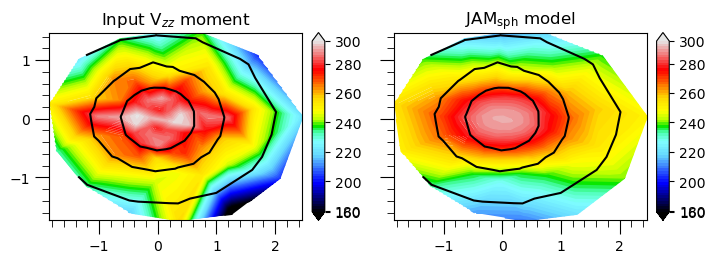


iter: 4  lambda: 591.1  chi2: 132.3  ratio: -3.492
p_free: 1.893 0.6734 0.000 1.408
h: 0.002364 0.000 0.000 -0.03857

iter: 5  lambda: 74.32  chi2: 157.3  ratio: 0.5926
p_free: 2.049 0.6363 0.2849 1.401
h: 0.0005588 0.004541 0.003427 -0.001698

Terminating on small function variation (ftol)
Final iter: 5  Func calls: 28  chi2: 157.3  Status: 2
Final p: 2.049 0.6363 0.2849 1.401


Success!

Best fit, [2.0492578  0.63627707 0.28485132 1.40133826 0.5        7.        ]
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1531-0105_2024_02_22_v1/SDSSJ1531-0105_2024_02_22_v1_space_jam.pkl
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


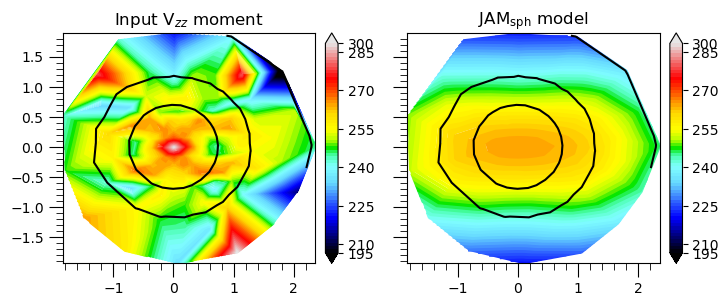


iter: 4  lambda: 2364.  chi2: 132.0  ratio: -3.328
p_free: 1.893 0.6734 0.000 1.409
h: 0.002319 0.000 0.000 -0.03765
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1627-0053_2024_02_22_v1/SDSSJ1627-0053_2024_02_22_v1_space_jam.pkl

iter: 4  lambda: 9457.  chi2: 131.3  ratio: -2.771
p_free: 1.893 0.6734 0.000 1.412
h: 0.002158 0.000 0.000 -0.03433
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 3.783e+04  chi2: 129.7  ratio: -1.549
p_free: 1.892 0.6734 0.000 1.421
h: 0.001707 0.000 0.000 -0.02511
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 1.513e+05  chi2: 128.1  ratio: -0.2478
p_free: 1.892 0.6734 0.000 1.435
h: 0.001005 0.000 0.000 -0.01108
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 4  lambda: 6.053e+05  chi2: 127.7  ratio: 0.4353
p_free: 1.891 0.6

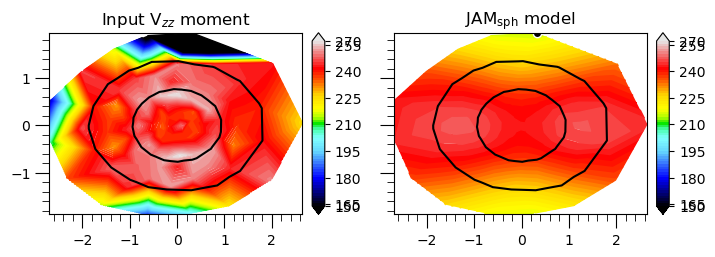

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ2303+1422_2024_02_22_v1/SDSSJ2303+1422_2024_02_22_v1_space_jam.pkl
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 6  lambda: 16.04  chi2: 145.2  ratio: 0.6695
p_free: 2.095 0.8006 0.000 1.465
h: -0.002197 0.000 0.000 0.002149
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 7  lambda: 16.04  chi2: 145.4  ratio: -0.9952
p_free: 2.113 0.8006 0.03004 1.454
h: 0.01749 0.000 0.03004 -0.01078
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 7 

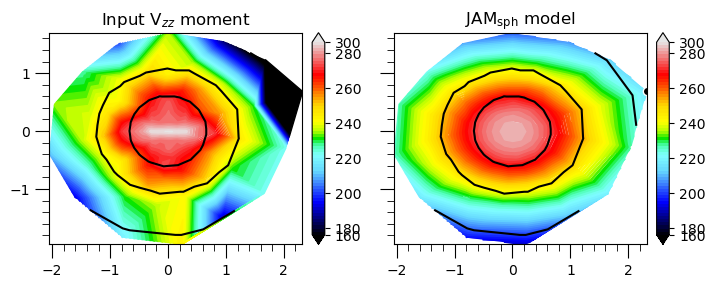

Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1630+4520_2024_02_22_v1/SDSSJ1630+4520_2024_02_22_v1_space_jam.pkl
Done.


In [24]:
# protect the entry point
if __name__ == '__main__':
    # report a message
    print('Starting task...')
    # create the process pool
    with ProcessPoolExecutor(8) as exe:
        # perform calculations
        results = exe.map(task, range(14))
    # report a message
    print('Done.')

________________________________

# Now we are going to rewrite space_jam.py to be able to deal with the new kinematics. Needs to be more general.

In [135]:
'''
12/19/2023 - Shawn Knabel (It's my birthday! :) )
This script creates a class called space_jam that is used to combine ppxf products with MGE products and perform MCMC with JAM to produce posteriors on the mass profiles and anisotropy of SLACS lenses.
It hinges upon work I have already done, but it's a step toward something more accessible for future peeps.
'''


################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.switch_backend('agg')
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob
import json


# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# ppxf/capfit
from ppxf.capfit import capfit

# mge fit
#import mgefit
#from mgefit.find_galaxy import find_galaxy
#from mgefit.mge_fit_1d import mge_fit_1d
#from mgefit.sectors_photometry import sectors_photometry
#from mgefit.mge_fit_sectors import mge_fit_sectors
#from mgefit.mge_print_contours import mge_print_contours
#from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.jam_sph_proj import jam_sph_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa
#from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_radial_mass import mge_radial_mass
from plotbin.symmetrize_velfield import symmetrize_velfield

# adamet
#from adamet.adamet import adamet
from adamet.corner_plot import corner_plot
# emcee
import emcee
import corner
#from IPython.display import display, Math

# import my packages
# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from total_mass_mge import total_mass_mge

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')

class space_jam:
    
    '''
    space_jam Purpose:
    -------------------
    For a SLACS galaxy with kinematic map and MGE surface brightness components already prepared, set up and run model inference about the mass profile and anisotropy using JAM.
    The mass sheet transform is explicitly fitted.
    
    Calling Sequence:
    -------------------
    from space_jam import space_jam
    from space_jam import load_space_jam
    
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    kinematics_full_dir = f'{data_dir}kinematics/'
    kin_dir =f'{kinematics_full_dir}{date_of_kin}/'
    jam_dir = f'{data_dir}jam_outputs/'
    
    # initialize
    we_jammin = space_jam(jam_dir, jampy_details_file,
                     obj_name, SN, mass_model, anisotropy, geometry, align, 
                    zlens, zsource, cosmo, fast_slow,
                   p0, bounds, sigpar, prior_type, lensprior, 
                   sampler_args, date_time, run_id, plot=False, overwrite=False, 
                   test_prior=False, constant_err=False, kinmap_test=None)
    # run mcmc
    we_jammin.run_mcmc()
    #plot
    we_jammin.summary_plot()
    
    Input Parameters
    ------------------
          
    jam_dir: str
        Directory where you want outputs in general to go (galaxy-specific)
        
    jampy_details_file: str
        Pkl file containing the inputs needed for JAM modeling (luminosity MGEs, Vrms, dVrms, axis rotation, etc.)
        
    obj_name: str
        Name of object for calling files, naming plots, etc. E.g. 'SDSSJ0029-0055'
    
    mass_model: str
        Mass model desired for MGE mass model. Default "power_law". Eventually will include composite model as well. I use this as part of my naming scheme. Not strictly necessary
    
    anisotropy: str
        Anisotropy of stellar orbits model for JAM fitting. Default "const". Eventually will include others as well.
        
    geometry: str
        Geometry of galaxy symmetry, axisymmetric or spherical. "axi" or "sph"
        
    align: str
        Alignment of velocity ellipsoid, spherical or cylindrical. "sph" or "cyl"
        
    zlens: float
        Redshift of lens deflector galaxy
        
    zsource: float
        Redshift of background source
    
    sigmapsf: float
        Standard deviation of the Gaussian PSF fit to the kinematics data
    
    cosmo: astropy.cosmology instance
        Assumed cosmology for distance measurement.
        
    fast_slow: str
        Fast or slow rotator. "fast" or "slow". Determines prior on intrinsic shape
        
    p0: array-like (N,)
        Mean values of N parameters from priors *if* the corresponding prior_type is "gaussian". Otherwise meaningless
        
    bounds: array-like (N, 2)
        Upper and lower bounds for parameter search space. Will be updated during the run according to certain model parameters (e.g. the possible intrinsic shapes)
        
    fix_pars: array-like (N,)
        If 1, parameter will be fixed to starting parameter
        
    lambda_int: float
        Explicit mass sheet parameter; if specified, will overwrite k_mst
        
    systematics_est: float
        Percent estimate of systematics if they have not been folded into the uncertainty dVrms_bin, e.g. 5%
        
    covariance_est: float
        Percent estimate of bin covariance, e.g. 2%
        
    
    '''
    
    def __init__(self,
                 jam_dir,
                 jampy_details_file,
                 obj_name,
                 mass_model, 
                 anisotropy, 
                 geometry, 
                 align, 
                 zlens, 
                 zsource, 
                 sigmapsf,
                 cosmo, 
                 fast_slow,
                 systematics_est,
                 covariance_est,
                 p0, 
                 bounds, 
                 sigpar, 
                 prior_type, 
                 lensprior,
                 fix_pars,
                 lambda_int,
                 minimization,
                 sampler_args, 
                 date_time, 
                 run_id,
                 plot=False, 
                 overwrite=False, 
                 test_prior=False, 
                 constant_err=False, 
                 kinmap_test=None):
    
        self.obj_name = obj_name
        self.obj_abbr = obj_name[4:9]
        self.run_id = run_id
        self.model_name = f'{obj_name}_{date_time}_v{run_id}'
        self.minimization = minimization
        self.sampler_args = sampler_args
        self.date_time = date_time
        self.run_id = run_id
        self.mass_model = mass_model
        self.anisotropy = anisotropy
        self.geometry = geometry
        self.align = align
        self.lensprior=lensprior
        self.p0 = p0
        self.sigpar = sigpar
        self.bounds = bounds
        self.prior_type = prior_type
        self.fix_pars = fix_pars
        self.lambda_int = lambda_int
        self.zlens = zlens
        self.zsource = zsource
        self.sigmapsf = sigmapsf
        self.cosmo = cosmo
        self.fast_slow = fast_slow
        self.systematics_est = systematics_est
        self.covariance_est = covariance_est
        
        # get model directory
        self.create_model_directory(jam_dir,
                                    date_time, 
                                    overwrite, 
                                    run_id,
                                    constant_err, 
                                    kinmap_test)
        
        # get details from pickle
        self.prepare_to_jam(jampy_details_file, 
                            constant_err, 
                            kinmap_test, 
                            geometry)
        
        # set up the labels and priors
        self.get_priors_and_labels()
        
        # approximate the covariance matrix
        self.approximate_covariance_matrix()
        
        
###########################################################
        
    def create_model_directory (self, 
                                jam_dir, 
                                date_time=None, 
                                overwrite=False, 
                                run_id=None,
                                constant_err=False, 
                                kinmap_test=None):

        self.model_dir = f'{jam_dir}{self.model_name}/'
        if not os.path.exists(self.model_dir):
            os.mkdir(self.model_dir)
        else:
            if overwrite==True:
                print(f'Files in {self.model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy.')
                    
        print()
        print('JAM Outputs to ', self.model_dir)
        print()


    ############################
    
    def prepare_to_jam(self, jampy_details_file, constant_err, kinmap_test, geometry):

        # take the surface density, etc from mge saved parameters
        with open(jampy_details_file, 'rb') as f:
            tommy_pickles = pickle.load(f)

        self.surf_lum = tommy_pickles.surf_density
        self.sigma_lum = tommy_pickles.mge_sigma
        self.qobs_lum = tommy_pickles.q
        #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
        #try:
        #    self.sigmapsf = tommy_pickles.kcwi_sigmapsf
        #except:
        #    self.sigmapsf = tommy_pickles.kcwi_sigmapst
        self.Vrms = tommy_pickles.Vrms_bin
        try:
            self.dVrms = tommy_pickles.dVrms_bin 
        except:
            self.dVrms = tommy_pickles.dVrms_bind # mistake in name
        self.V = tommy_pickles.V_bin
        self.dV = tommy_pickles.dV_bin
        self.xbin = tommy_pickles.xbin_phot
        self.ybin = tommy_pickles.ybin_phot
        self.reff = tommy_pickles.reff
        
        # additional kwargs needed for jam
        self.goodbins = np.isfinite(self.Vrms/self.dVrms)
        # These parameters are passed to JAM
        try:
            self.distance = self.cosmo.angular_diameter_distance(self.zlens).value
        except:
            self.distance = self.cosmo.angular_diameter_distance(self.zlens).to_numpy()[0]
        self.normpsf = 1.
        self.pixsize = 0.1457#kcwi_scale,      
        self.break_factor = 20 #200
        
        #### Here is where we can change the velocity maps to test systematic variations
        if constant_err==True:
            print('Using constant error of 5% instead of measured bin error')
            dVrms = 0.05 * self.Vrms
        if kinmap_test is not None:
            print('Testing Vrms map and error multiplied by a factor', kinmap_test)
            Vrms = kinmap_test * self.Vrms
            dVrms = kinmap_test * self.dVrms

        # prepare MGEs for axisymmetric or spherical geometry
        if geometry=='axi':
            # Get the effective shape and (not) effective radius from the half-light isophote
            _, _, eps_eff, _ = mge_half_light_isophote(self.surf_lum, self.sigma_lum, self.qobs_lum)
            self.qobs_eff = 1-eps_eff
        elif geometry=='sph':
            # Circularize MGEs if geometry is spherical
            print(self.sigma_lum, self.qobs_lum)
            self.sigma_lum, self.qobs_lum = self.circularize_mge()
            self.qobs_eff = 1

    ###############
    def get_priors_and_labels (self):
    
        ###### axisymmetric geometry
        if self.geometry=='axi':
            try:
                if any(self.prior_type==None):
                    self.prior_type=['uniform','uniform','uniform','uniform','uniform','uniform']  
            except:
                if self.prior_type==None:
                    self.prior_type=['uniform','uniform','uniform','uniform','uniform','uniform']  

            # mass model labels
            if self.mass_model=='power_law':
                label0 = r'$\gamma$'
            elif self.mass_model=='nfw':
                label0 = r"$f_{\rm DM}$"

            # intrinsic axis ratio
            # The calculation of the inclination from q_intr involves a few steps
            bound_q_intr_lo, bound_q_intr_hi = self.get_bounds_on_q_intr_eff()
            self.bounds[0][1] = bound_q_intr_lo
            self.bounds[1][1] = bound_q_intr_hi  

            label1 =  r"$q_{\rm intr}$"
            # priors based on fast/slow
            if self.fast_slow == 'fast':
                # make the prior a gaussian from Weijman 2014
                self.p0[1] = 0.25
                self.sigpar[1] = 0.14
                self.prior_type[1]='gaussian'
            elif self.fast_slow == 'slow':
               # make the prior a gaussian from Li 2018
                self.p0[1] = 0.74
                self.sigpar[1] = 0.08
                self.prior_type[1]='gaussian'  
                # bound it lower by the max of either bound_q_intr_lo or q_intr > 0.6
                self.bounds[0][1] = np.max([0.6, bound_q_intr_lo])

            # anisotropy priors and labels
            if (self.align == 'sph') & (self.anisotropy == 'const'):
                bound_ani_ratio_hi = 2.0 # anisotropy of spherical can be up to 2.0
                label2 = r"$\sigma_{\theta}/\sigma_r$"
            elif (self.align == 'cyl') & (self.anisotropy == 'const'):
                bound_ani_ratio_hi = 1.0 # anisotropy of cylindrical CANNOT be up to 2.0
                label2 = r"$\sigma_z/\sigma_R$"
            elif self.anisotropy == 'OM':
                label2 = r"$a_{ani}$"

            # shape and anisotropy secondary bounds
            self.shape_anis_bounds = np.array([0.0, bound_ani_ratio_hi])
            # set up empty array and add the ratios here so they don't have to be calculated again
            self.anisotropy_ratio_samples = np.array([], dtype='f')

            # einstein radius is universal across models
            label3 = r"$\theta_E$"

            # 11/14/23 - lambda_int is now a parameter k_mst, but the label will be the same, lambda_int is universal across models
            label4 = r'$\lambda_{int}$'
            # set up empty array to add lambda_ints so they don't have to be calculated again
            self.lambda_int_samples = np.array([], dtype='f')

            # r_scale is universal across models
            label5 = r'$a_{MST}$'

            self.labels = [label0, label1, label2, label3, label4, label5]

        elif self.geometry=='sph':
            if any(self.prior_type==None):
                self.prior_type=['uniform','uniform','uniform','uniform','uniform']  

            # mass model labels
            if self.mass_model=='power_law':
                label0 = r'$\gamma$'
            elif self.mass_model=='nfw':
                label0 = r"$f_{\rm DM}$"

            # parameter 1 is q, which is not here...

            # anisotropy priors and labels
            if (self.align == 'sph') & (self.anisotropy == 'const'):
                bound_ani_ratio_hi = 2.0 # anisotropy of spherical can be up to 2.0
                label2 = r"$\sigma_{\theta}/\sigma_r$"
            elif self.anisotropy == 'OM':
                label2 = r"$a_{ani}$"
            self.shape_anis_bounds = np.array([0.0, bound_ani_ratio_hi])
            # set up empty array and add the ratios here so they don't have to be calculated again
            self.anisotropy_ratio_samples = np.array([], dtype='f')

            # einstein radius is universal across models
            label3 = r"$\theta_E$"

            # 11/14/23 - lambda_int is now a parameter k_mst, but the label will be the same, lambda_int is universal across models
            label4 = r'$\lambda_{int}$'
            # set up empty array to add lambda_ints so they don't have to be calculated again
            self.lambda_int_samples = np.array([], dtype='f')

            # r_scale is universal across models
            label5 = r'$a_{MST}$'

            self.labels = [label0, label2, label3, label4, label5]  

        print('Priors are now ', self.prior_type)
        print('Mean prior values are ', self.p0)
        
        
    ###################
    def get_bounds_on_q_intr_eff (self):
    
        # intrinsic shape must be flatter than the observed shape
        q_intr_eff_bound_hi = self.qobs_eff
        # all MGE components must be flatter than observed
        qobs_min = np.min(self.qobs_lum)
        inc_min = np.arccos(qobs_min)
        q_intr_eff_bound_lo = np.sqrt( (self.qobs_eff**2 - qobs_min**2)/(1 - qobs_min**2))
        #print('qobs_min ', qobs_min)
        #print('q_intr lower bound from qobs_min ', q_intr_eff_bound_lo)
        inc_bound_lo = np.sqrt( np.rad2deg(np.arcsin( (1 - qobs_min**2) / (1 - q_intr_eff_bound_lo**2))) ) # check what this minimum inclination is
        #print('minimum inclination from qobs_min ', inc_bound_lo)


        return q_intr_eff_bound_lo, q_intr_eff_bound_hi
    
    
    ###################
    # function to estimate approximate covariance matrix
    def approximate_covariance_matrix (self):
    
        Vrms = self.Vrms
        dVrms = self.dVrms

        # make a covariance matrix without systematics or covariance
        cov_matrix_no_cov = np.identity(dVrms.size) * dVrms**2

        # add constant 5% systematics in quadrature
        cov_matrix_no_cov_w_syst = cov_matrix_no_cov + np.identity(dVrms.size) * (Vrms*self.systematics_est)**2

        # calculate grid of Vrms for off-diagonal covariance terms
        xx, yy = np.meshgrid(Vrms, Vrms)
        off_diagonals = (xx * yy * self.covariance_est**2)
        # make diagonal 0
        off_diagonals = off_diagonals - np.identity(Vrms.size) * off_diagonals.diagonal()

        # add the off-diagonals to the covariance matrix
        self.covariance_matrix = cov_matrix_no_cov_w_syst + off_diagonals
        
    ###################
    # function to evaluate the prior for each given sample
    def jam_lnprior (self, pars, plot=False):
        '''
        Calculate the prior likelihood for the sampled parameters
        pars
        mu - mean of prior
        sigma - width of prior
        prior_type - uniform, gaussian, log_uniform, log_normal
        '''

        pars = np.array(pars)
        mu = np.array(self.p0)
        sigma = np.array(self.sigpar)

        if any(pars < self.bounds[0]) or any(pars > self.bounds[1]):
            #print('outside bounds')
            lnprior = -np.inf

        else:
            lnprior=np.ones_like(pars)
            for i in range(len(pars)):
                if self.prior_type[i]=='uniform':
                    lnprior[i]=0.
                elif self.prior_type[i]=='gaussian':
                    lnprior[i]=np.log(1.0/(np.sqrt(2*np.pi)*sigma[i]))-0.5*(pars[i]-mu[i])**2/sigma[i]**2

        return np.sum(lnprior)


    ###############################################################################
    # set up new anisotropy functions and probability functions to be fit

    def jam_lnprob (self, pars, lambda_int=None, plot=False, test_prior=False, bestfit=False):

        """
        Return the probability of the model, given the data, assuming priors

        """
        
        lnprior = self.jam_lnprior (pars)

        if test_prior == True:
            return lnprior

        if np.isinf(lnprior) or np.isnan(lnprior):
            # Update the arrays of ratios and lambda_ints
            if bestfit == False:
                self.lambda_int_samples = np.append(self.lambda_int_samples, 'nan')
                self.anisotropy_ratio_samples = np.append(self.anisotropy_ratio_samples, 'nan')
                self.chi2s = np.append(self.chi2s, np.inf)
                return -np.inf
            else:
                print('bestfit is excluded by the priors')
                return 0, 0, 0

        else:
            # axisymmetric model takes jam_axi_proj
            if self.geometry == 'axi':
                # parameters for fitting
                # Mass model
                if self.mass_model=='power_law':
                    gamma, q, anis_param, theta_E, k_mst, a_mst = pars
                    # let f_dm = 0 for a power law
                    f_dm = 0
                elif self.mass_model=='nfw':
                    f_dm, q, anis_param, lg_ml, k_mst, a_mst = pars
                    # gamma = -1 for NFW
                    gamma = -1
                # Anisotropy is dependent on model
                if self.anisotropy=='const':
                    logistic=False
                    k_ani = anis_param # k_ani is a parameter [0, 1]
                    ratio = self.anisotropy_ratio_from_k_and_q_intr(k_ani, q)#, self.shape_anis_bounds[1]) # allowed ratio depends on the intrinsic q proposed and fast/slow
                    beta = np.full_like(self.qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                    # lower bound is constrained by q as R(q) = sqrt(0.3 + 0.7*q) # This should already be in place, but reject it in case it's bad
                    # This is a constraint from intrinsic shape
                    R_q = np.sqrt(0.3 + 0.7*q)
                    if ratio < R_q:
                        anisotropy_constraint = 0
                    else:
                        anisotropy_constraint = 1
                elif self.anisotropy=='OM':
                    logistic=True
                    a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                    r_a = a_ani*reff
                    beta_0 = 0 # fully isotropic
                    beta_inf = 1 # fully radially anisotropic
                    alpha = 2 # sharpness of transition
                    beta = np.array([r_a, beta_0, beta_inf, alpha])
                    anisotropy_constraint = 1 # doesn't apply here
                else:
                    print('Something is wrong')
                # Continue if good to go
                if anisotropy_constraint == 1: # i.e. the constraint from q is okay

                    # Get the inclination from the intrinsic shape
                    inc = self.calculate_inclination_from_qintr_eff (q)

                    # Obtain total mass profile
                    total_mass = total_mass_mge(self.surf_lum, self.sigma_lum, self.qobs_lum, 
                                                 self.mass_model, self.qobs_eff, self.reff, self.break_factor, 
                                               self.zlens, self.zsource, self.cosmo,
                                                 gamma, f_dm, theta_E, k_mst, a_mst, lambda_int=self.lambda_int, 
                                                 ngauss=30, inner_slope=2, outer_slope=3, 
                                                 quiet=1, plot=plot, skip_mge=False)
                    surf_pot = total_mass.surf_pot
                    sigma_pot = total_mass.sigma_pot
                    qobs_pot = total_mass.qobs_pot
                    lambda_int = total_mass.lambda_int

                    # reject if negative mass calculated
                    if lambda_int==0:
                        lnprob = -np.inf
                        # pdate the arrays of ratios and lambda_ints
                        if (bestfit == False) & (self.minimization=='MCMC'):
                            self.lambda_int_samples = np.append(self.lambda_int_samples, lambda_int)
                            self.anisotropy_ratio_samples = np.append(self.anisotropy_ratio_samples, ratio)
                            self.chi2s = np.append(self.chi2s, np.inf)
                            return lnprob
                        elif self.minimization=='lsq':
                            residual = np.full_like(self.Vrms[self.goodbins], np.inf)
                            return residual
                        else:
                            print('bestfit is results in negative mass')
                            return 0, 0, 0
                    else:
                        # run JAM
                        # ignore central black hole
                        mbh=0.
                        # make the JAM model
                        jam = jam_axi_proj(self.surf_lum, self.sigma_lum, self.qobs_lum, surf_pot, sigma_pot, qobs_pot,
                                           inc, mbh, self.distance, self.xbin, self.ybin, 
                                            align=self.align, beta=beta, logistic=logistic,
                                           data=self.Vrms, errors=self.dVrms, goodbins=self.goodbins,
                                           pixsize=self.pixsize, sigmapsf=self.sigmapsf, normpsf=self.normpsf, 
                                           plot=plot,  quiet=1, ml=1, nodots=True)
                        # Update the arrays of ratios and lambda_ints
                        if (bestfit == False) & (self.minimization=='MCMC'):
                            model = jam.model[self.goodbins]
                            data = self.Vrms[self.goodbins]
                            chi2 = (model - data).T @ np.linalg.inv(self.covariance_matrix) @ (model - data)
                            lnprob = -0.5*chi2 + lnprior
                            self.lambda_int_samples = np.append(self.lambda_int_samples, lambda_int)
                            self.anisotropy_ratio_samples = np.append(self.anisotropy_ratio_samples, ratio)
                            self.chi2s = np.append(self.chi2s, chi2)
                            return lnprob
                        elif (bestfit == False) & (self.minimization=='lsq'):
                            residual = (self.Vrms[self.goodbins] - jam.model[self.goodbins])/self.dVrms[self.goodbins]
                            return residual
                        else:
                            surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))
                            return jam, surf_potential, lambda_int
                else:
                    # if the anisotropy constraint is violated
                    lnprob = -np.inf # reject this one
                    # Update the arrays of ratios and lambda_ints
                    if (bestfit == False) & (self.minimization=='MCMC'):
                        self.lambda_int_samples = np.append(self.lambda_int_samples, lambda_int)
                        self.anisotropy_ratio_samples = np.append(self.anisotropy_ratio_samples, ratio)
                        self.chi2s = np.append(self.chi2s, np.inf)
                        return lnprob
                    elif (bestfit == False) & (self.minimization=='lsq'):
                        residual = np.inf
                        return residual
                    else:
                        surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))
                        return jam, surf_potential, lambda_int
                        

            # sph geometry is a different jam function
            elif self.geometry == 'sph':
                # parameters for fitting
                # Mass model
                if self.mass_model=='power_law':
                    gamma, anis_param, theta_E, k_mst, rs_mst = pars
                    # let f_dm = 0 for a power law
                    f_dm = 0
                elif self.mass_model=='nfw':
                    f_dm, anis_param, lg_ml, k_mst, rs_mst = pars
                    # gamma = -1 for NFW
                    gamma = -1
                # Anisotropy is dependent on model
                if self.anisotropy=='const':
                    logistic=False
                    ratio = anis_param
                    beta = np.full_like(self.qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                    rani = None
                elif self.anisotropy=='OM':
                    logistic=True
                    a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                    r_a = a_ani*reff
                    # put in r_ani keyword
                    beta_0 = 0 # fully isotropic
                    beta_inf = 1 # fully radially anisotropic
                    alpha = 2 # sharpness of transition
                    beta = np.array([r_a, beta_0, beta_inf, alpha])
                # Obtain total mass profile
                total_mass = total_mass_mge(self.surf_lum, self.sigma_lum, self.qobs_lum, 
                                             self.mass_model, self.qobs_eff, self.reff, self.break_factor, 
                                           self.zlens, self.zsource, self.cosmo,
                                             gamma, f_dm, theta_E, k_mst, a_mst, lambda_int=self.lambda_int, 
                                             ngauss=30, inner_slope=2, outer_slope=3, 
                                             quiet=1, plot=False, skip_mge=False)
                surf_pot = total_mass.surf_pot
                sigma_pot = total_mass.sigma_pot
                qobs_pot = total_mass.qobs_pot
                lambda_int = total_mass.lambda_int
                # reject if negative mass calculated
                if lambda_int==0:
                    lnprob = -np.inf
                    if bestfit == False:
                        self.lambda_int_samples = np.append(self.lambda_int_samples, lambda_int)
                        self.anisotropy_ratio_samples = np.append(self.anisotropy_ratio_samples, ratio)
                        self.chi2s = np.append(self.chi2s, np.inf)
                    return lnprob
                # get radius of bin centers
                rad_bin = np.sqrt(xbin**2 + ybin**2)
                # ignore central black hole
                mbh=0.
                # There is no "goodbins" keyword for jam_sph_proj, so I need to adjust the data as such
                rms = rms[goodbins]
                erms = erms[goodbins]
                rad_bin = rad_bin[goodbins]
                
                # sort by bin radius
                sort = np.argsort(rad_bin)
                rad_bin = rad_bin[sort]
                Vrms = Vrms[sort]
                dVrms = dVrms[sort]
                goodbins = goodbins[sort]

                # Now run the jam model
                jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot, 
                                   mbh, distance, rad_bin, #xbin, ybin, align=align, 
                                    beta=beta, logistic=logistic, rani=r_a,
                                   data=rms, errors=erms, #goodbins=goodbins, # there is no goodbins
                                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                                   plot=plot, quiet=1, ml=1)#, nodots=True) # there is no nodots
                ####### 10/02/23 - for now, we will run jam_axi_proj, which is the same as jam_sph_proj in the spherical limit that q=1
                #inc=90
                #jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 #                  inc, mbh, distance, xbin, ybin, 
                 #                   align=align, beta=beta, logistic=logistic,
                 #                  data=rms, errors=erms, goodbins=goodbins,
                 #                  pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                 #                  plot=plot,  quiet=1, ml=1, nodots=True)
                # Update the arrays of ratios and lambda_ints
                if (bestfit == False) & (self.minimization=='MCMC'):
                    model = jam.model[self.goodbins]
                    data = self.Vrms[self.goodbins]
                    chi2 = (model - data).T @ np.linalg.inv(self.covariance_matrix) @ (model - data)
                    lnprob = -0.5*chi2 + lnprior
                    self.lambda_int_samples = np.append(self.lambda_int_samples, lambda_int)
                    self.anisotropy_ratio_samples = np.append(self.anisotropy_ratio_samples, ratio)
                    self.chi2s = np.append(self.chi2s, chi2)
                    return lnprob
                elif (bestfit == False) & (self.minimization=='lsq'):
                    residual = (self.Vrms[goodbins] - jam.model[goodbins])/self.dVrms[goodbins]
                    return residual
                else:
                    surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))
                    return jam, surf_potential, lambda_int
        
    ###################
    # function to save the space_jam object
    def save_space_jam(self):
        print(f'Saving to {self.model_dir}{self.model_name}_space_jam.pkl')
        with open(f'{self.model_dir}{self.model_name}_space_jam.pkl','wb') as f:
            tommy_pickles = pickle.dump(self, f)
    
    ###################
    # function to run mcmc
    def run_mcmc(self):
        # set to MCMC
        self.minimization = 'MCMC'
        # set up chi2s to be saved for later use
        self.chi2s = np.array([], dtype=float)
        # Do the fit
        print("Started Emcee please wait...")
        print("Progress is printed periodically")
        nstep, nwalkers, ndim = self.sampler_args
        # set initial walker positions
        self.initial_state = np.random.uniform(self.bounds[0], self.bounds[1], [nwalkers,ndim])
        self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.jam_lnprob)#, kwargs=self.__dict__) # Unsure about this one
        self.sampler.run_mcmc(self.initial_state, nstep, progress=True)
        self.pars = self.sampler.get_chain(flat=True)
        self.lnprob = self.sampler.get_log_prob(flat=True)
        self.bestfit = self.pars[np.nanargmax(self.lnprob)]  # Best fitting parameters
        print('n accepted unique parameters', len(np.unique(self.pars[:,0])))
        self.index_accepted_samples()
        self.save_space_jam()
        print("Job's finished!")
        
    ###################
    # least-squares fit for ease of testing
    def fit_lsq(self):
        
        '''
        Least-squares fit for testing and quick result.
        '''
        
        # set to lsq
        self.minimization='lsq'
        
        # set up chi2s to be saved for later use
        self.chi2s = np.array([], dtype=float)
        
        sol = capfit(self.jam_lnprob, self.p0, bounds=self.bounds, verbose=2, fixed=self.fix_pars)
        if sol.success==True:
            print()
            print('Success!')
            print()
        else:
            print()
            print('Fit failed to meet convergence criteria.')
            print()

        # bestfit paramters
        #q = sol.x[0]
        #inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
        #anis_ratio = sol.x[1]
        #gamma_fit = sol.x[2]
        print('Best fit,', sol.x)#anis_ratio, gamma_fit)

        # covariance matrix of free parameters
        cov = sol.cov
        # qerr doesn't matter but is the first index
        #anis_ratio_err = np.sqrt(sol.cov.diagonal()[1])
        #gamma_err = np.sqrt(sol.cov.diagonal()[2])

        # plot the best fit
        #kwargs['plot'] = 1
        #kwargs['return_mge'] = True
        #surf_pot, sigma_pot, qobs_pot, chi2 
        surf_pot, sigma_pot, qobs_pot \
            = self.jam_lnprob(sol.x, plot=True, bestfit=True)#**kwargs)
        #plt.savefig(f'{jam_output_dir}{obj_name}_pl_const_axicyl_fit.png')
        plt.pause(1)

        # take chi2/dof
        #dof = len(Vrms)
        #chi2_red = chi2/dof

        # calculate the enclosed mass
        #mass_enclosed, gamma_avg, profile_radii, profile_1d \
#                    = calculate_mass_and_slope_enclosed(surf_pot, sigma_pot, qobs_pot, self.distance, radius=self.theta_E, plot=True)

        #print('Mass enclosed, avg gamma', mass_enclosed, gamma_avg)

    ###################
    # function to plot summary
    def summary_plot(self, save=False):

        """
        Print the best fitting solution with uncertainties.
        Plot the final corner plot with the best fitting JAM model.
        """

        # jam the best fit
        jam, surf_potential, lambda_int = self.jam_lnprob(self.bestfit, plot=True, test_prior=False, bestfit=True)
        plt.pause(1)
        if jam==0:
            return 'Cannot plot this bestfit'
        rms_model = jam.model
        flux_model = jam.flux

        plot_pars = self.pars.copy()
        plot_bounds = np.array(self.bounds).copy()#self.bounds.copy()
        plot_truths = self.p0.copy()
        #truths should only be for gamma, theta_E and q_intr
        plot_truths[2] = 0
        plot_truths[-1] = 0
        plot_truths[-2] = 0
        # substitute the plot parameters with the ratios and lambda_ints
        plot_pars[:,2] = self.anisotropy_ratio_accepted
        plot_pars[:,-2] = self.lambda_int_accepted
        # bounds should change
        plot_bounds[0][2] = self.shape_anis_bounds[0]
        plot_bounds[1][2] = self.shape_anis_bounds[1]
        plot_bounds[0][-2] = 0.8
        plot_bounds[1][-2] = 1.2

        # calculate uncertainties in posterior
        plot_bestfit = plot_pars[np.nanargmax(self.lnprob)]
        print('bestfit', plot_bestfit)
        perc = np.percentile(plot_pars, [15.86, 84.14], axis=0)  # 68% interval
        sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
        chi2_bestfit = self.chi2s[self.index_accepted][np.nanargmax(self.lnprob)]

        # For plotting, only show the finite probability points
        finite = np.isfinite(self.lnprob)

        # Produce final corner plot without trial values and with best fitting JAM
        plt.rcParams.update({'font.size': 14})
        plt.clf()
        corner_plot(plot_pars[finite], self.lnprob[finite], labels=self.labels, extents=plot_bounds, truths=plot_truths, truth_color='k', fignum=1)

        dx = 0.24
        yfac = 0.87
        fig = plt.gcf()
        fig.set_size_inches((12,12))
        fig.tight_layout()

        i = 0                          
        # annotate the model results
        plt.annotate(f'chi2 = {np.around(chi2_bestfit, 2)}', (0.30, 0.97-(1+len(self.labels))*0.03), xycoords='figure fraction', fontsize=16)
        for label, best, sig in zip(self.labels, plot_bestfit, sig_bestfit):
            string = f"{label} = {best:#.4g} ± {sig:#.2g}"
            plt.annotate(string, (0.30, 0.94-i*0.03), xycoords='figure fraction', fontsize=16) 
            i = i+1

        # plot circular reff
        reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

        # plot data
        fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
        rms1 = self.Vrms.copy()
        rms1[self.goodbins] = symmetrize_velfield(self.xbin[self.goodbins], self.ybin[self.goodbins], self.Vrms[self.goodbins])
        vmin, vmax = np.percentile(rms1[self.goodbins], [0.5, 99.5])
        plot_velfield(self.xbin, self.ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                      colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
        plt.tick_params(labelbottom=False)
        plt.ylabel('arcsec')
        ax = plt.gca()
        ax.add_patch(reff_plot)

        # plot circular reff again... can only patch one time
        reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

        # plot model
        fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
        plot_velfield(self.xbin, self.ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                      colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
        #plt.tick_params(labelbottom=False)
        plt.xlabel('arcsec')
        plt.ylabel('arcsec')
        ax = plt.gca()
        ax.add_patch(reff_plot)

        if save==True:
            plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.png', bbox_inches='tight')
            plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.pdf', bbox_inches='tight')

        plt.show()
        plt.pause(1)

    #################
    # function to identify where samples were updated (accepted) vs rejected, so I can index the "anisotropy_ratio_samples" etc. properly                              
    def index_accepted_samples(self):

        # create an array of the indices that are to be accepted for each of the steps
        self.index_accepted = np.zeros(self.pars.shape[0], dtype=int)

        # every step includes the initial state
        every_step = np.concatenate((self.initial_state, self.sampler.flatchain))
        nwalkers = self.sampler_args[1]

        # loop through each of hte walkers individually
        for i in range(nwalkers):
            # this walker will be every "nwalkers" of the parameters
            this_walker = every_step[i::nwalkers]
            # start with the initial state, it will be replaced by the first one that was accepted
            last_accepted_state = this_walker[0]
            # start with the index of the initial state
            last_accepted_index = i
            # loop through the steps of this walker
            for j, index in enumerate(this_walker):
                # skip the initialization
                if j==0:
                    continue
                # if the walker is not equal to the last accepted state, then a new sample was accepted
                # the param_index is the index of the parameter in the shape nwalkers*nsteps
                param_index = (j-1)*nwalkers+i
                # the replace_index is the index of the "lambda_int" samples, shape (nwalkers+1)*nsteps to include the initial state
                replace_index = j*nwalkers+i
                if np.all(this_walker[j] != last_accepted_state):
                    # report this index to the array
                    self.index_accepted[param_index] = replace_index
                    last_accepted_state = this_walker[j]
                    last_accepted_index = replace_index
                else:
                    self.index_accepted[(j-1)*nwalkers+i] = last_accepted_index

        # save the accepted lambda_int and anisotropy
        self.anisotropy_ratio_accepted = np.zeros(self.pars.shape[0], dtype=float)
        self.lambda_int_accepted = np.zeros(self.pars.shape[0], dtype=float)
        # loop through the steps
        for i in range(self.pars.shape[0]):
            self.anisotropy_ratio_accepted[i] = self.anisotropy_ratio_samples[self.index_accepted[i]]
            self.lambda_int_accepted[i] = self.lambda_int_samples[self.index_accepted[i]]


    ###############################################################################


    def check_convergence(samples): # stolen from https://github.com/exoplanet-dev/exoplanet/blob/2e66605f3d51e4cc052759438657c41d646de446/paper/notebooks/scaling/scaling.py#L124
        tau = emcee.autocorr.integrated_time(samples, tol=0)
        num = samples.shape[0] * samples.shape[1]
        converged = np.all(tau * 1 < num)
        converged &= np.all(len(samples) > 50 * tau)
        return converged, num / tau


    ###############################################################################


    # make a 2D gaussian

    def make_2d_gaussian_xy (x, y, surf_pot, sigma_pot, qobs_pot):
        gauss = surf_pot * np.exp( - x**2 / (2 * sigma_pot**2 * qobs_pot**2) -  y**2 / (2 * sigma_pot**2))
        return gauss


    ###############################################################################


    # define a function that will circularize the MGE

    def circularize_mge (self):

        sigma_circ = self.sigma_lum*np.sqrt(self.qobs_lum)
        qobs_circ = np.ones_like(self.qobs_lum)

        return sigma_circ, qobs_circ


    ###############################################################################


    def calculate_inclination_from_qintr_eff (self, qintr_eff):#, x_bound_hi ):

        #f = lambda x: np.sqrt( (qobs_eff**2 - x)/(1 - x) ) - q_intr
        #xx = fsolve(f, x_bound_hi)[0]

        y = (1 - self.qobs_eff**2)/(1 - qintr_eff**2) # sin^2(inclination)
        inclination = 180/np.pi*np.arcsin(np.sqrt(y))

        return inclination


    ###############################################################################


    def anisotropy_ratio_from_k_and_q_intr(self, k, q_intr):

        R_q = np.sqrt(0.3 + 0.7*q_intr)

        ratio = R_q + (self.shape_anis_bounds[1] - R_q) * k

        return ratio


# Test it out.

In [136]:
date_of_kin = '2024_02_15'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'

In [145]:
i=0
obj_name = obj_names[i]
kin_dir = f'{kinematics_dir}{obj_name}/'
jam_dir = f'{jam_output_dir}{obj_name}/'
jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='cyl'
zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
#cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
systematics_est = 0.05 # %
covariance_est = 0.02 # %
p0 = [2.0, 0.4, 0.9, 1.0, 0.5, 7] # gamma0, q0, k_ani, einstein radius, k_mst, a_mst
bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
          [2.8, 1.0,   1.0, 2.0, 1.0, 10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
fix_pars = [0, 0, 0, 0, 1, 1]
lambda_int= 1.0
nstep = 10
nwalkers = 12
ndim = 6
minimization = 'lsq'
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 2

welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                 obj_name, mass_model, anisotropy, geometry, align, 
                                zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow, 
                               systematics_est=systematics_est, covariance_est=covariance_est,
                               p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                               minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)

welcome_to_the_jam.fit_lsq()
#welcome_to_the_jam.save_space_jam()

Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/SDSSJ0029-0055_2024_02_22_v2/ will be overwritten.

JAM Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/SDSSJ0029-0055_2024_02_22_v2/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Start lambda: 89.73  chi2: 845.9
Start p_free: 2.000 0.7400 0.9000 1.000
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 1  lambda: 89.73  chi2: 88.15  ratio: 0.9964
p_free: 2.105 0.8334 0.

In [138]:
i=0
obj_name = obj_names[i]
kin_dir = f'{kinematics_dir}{obj_name}/'
jam_dir = f'{jam_output_dir}{obj_name}/'
jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='sph'
zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
#cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
systematics_est = 0.05 # %
covariance_est = 0.02 # %
p0 = [2.0, 0.4, 0.9, 1.0, 0.5, 7] # gamma0, q0, k_ani, einstein radius, k_mst, a_mst
bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
          [2.8, 1.0,   1.0, 2.0, 1.0, 10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
fix_pars = [0, 0, 0, 0, 1, 1]
lambda_int= 1.0
nstep = 10
nwalkers = 12
ndim = 6
minimization = 'lsq'
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 2

welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                 obj_name, mass_model, anisotropy, geometry, align, 
                                zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow, 
                               systematics_est=systematics_est, covariance_est=covariance_est,
                               p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                               minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)

welcome_to_the_jam.run_mcmc()
#welcome_to_the_jam.save_space_jam()

Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/SDSSJ0029-0055_2024_02_22_v2/ will be overwritten.

JAM Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/SDSSJ0029-0055_2024_02_22_v2/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]
Started Emcee please wait...
Progress is printed periodically
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals >

  0%|                                                             | 0/10 [00:00<?, ?it/s]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 10%|█████▎                                               | 1/10 [00:02<00:22,  2.50s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 20%|██████████▌                                          | 2/10 [00:06<00:28,  3.52s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 30%|███████████████▉                                     | 3/10 [00:12<00:31,  4.52s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 40%|█████████████████████▏                               | 4/10 [00:18<00:29,  4.97s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 50%|██████████████████████████▌                          | 5/10 [00:22<00:23,  4.72s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 60%|███████████████████████████████▊                     | 6/10 [00:30<00:23,  5.81s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 70%|█████████████████████████████████████                | 7/10 [00:36<00:17,  5.84s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 80%|██████████████████████████████████████████▍          | 8/10 [00:47<00:15,  7.56s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


 90%|███████████████████████████████████████████████▋     | 9/10 [00:55<00:07,  7.61s/it]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


100%|████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.31s/it]

n accepted unique parameters 51
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/SDSSJ0029-0055_2024_02_22_v2/SDSSJ0029-0055_2024_02_22_v2_space_jam.pkl
Job's finished!


In [140]:
welcome_to_the_jam.summary_plot()
plt.pause(1)

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
bestfit [2.08524101 0.67689562        nan 1.25315145        nan 5.80109623]


/tmp/ipykernel_132749/3900303909.py:891: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
